<a href="https://colab.research.google.com/github/koava36/Numerical_Linear_Algebra_Project/blob/main/SpecRNN_%2B_FastH_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastH Installation

The following cell clones code from github and runs "test_case.py". Remember to **activate GPU** in Runtime->Change Run Time Type. 

In [1]:
!git clone https://github.com/alexandermath/fasth
!python -m pip install ninja
%cd fasth

Cloning into 'fasth'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 95 (delta 47), reused 52 (delta 20), pack-reused 0
Unpacking objects: 100% (95/95), done.
     |████████████████████████████████| 112kB 17.7MB/s 
/content/fasth


In [11]:
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn

In [2]:
import torch
from fasth_wrapper import Orthogonal 

class LinearSVD(torch.nn.Module): 
	def __init__(self, input_size, output_size, m=14, sig_mean = 1.0, r=0.01, strategy='fast'): 
		super(LinearSVD, self).__init__()
		self.input_size = input_size
		self.output_size = output_size

		self.sig_mean = sig_mean
		self.r = r

		self.U = Orthogonal(input_size, m, strategy=strategy)
		D = torch.empty(min(input_size, output_size), 1, requires_grad=True)
		self.D = nn.Parameter(D.clone().uniform_(0.99, 1.01))
		self.V = Orthogonal(output_size, m, strategy=strategy)

	def forward(self, X):
	  X = self.U(X)
	  if self.output_size < self.input_size:
	    X = X[:self.output_size - self.input_size, :]
	  #X = (2 * self.r * (torch.sigmoid(self.D) - 0.5) + self.sig_mean) * X
	  if self.output_size > self.input_size:
	    X = torch.cat([X, torch.zeros(self.output_size - self.input_size, X.shape[1])])
	  X = self.V(X)
	  return X 


Compiling our c++/cuda code, this usually takes 1-2 min. 
Finished compilation, took: 70.9857s


In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F

class Logit(nn.Module):
    def __init__(self, rnn_num_units=112, output_size=10):
      super(self.__class__,self).__init__()
      self.linear = nn.Linear(rnn_num_units, output_size)
      
    def forward(self, h):
      h = self.linear(h)

      return F.log_softmax(h)

class RNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, input_size=2, rnn_num_units=112):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.linear = nn.Linear(input_size, 28)
        self.rnn_update = nn.Linear(28 + rnn_num_units, rnn_num_units)
        self.act = nn.Tanh()
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x = self.linear(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = self.act(h_next)
        
        assert h_next.size() == h_prev.size()


        return h_next, h_next
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [4]:
class SpecRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, input_size=2, rnn_num_units=112, m=14, strategy='fast'):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.linear = nn.Linear(input_size, rnn_num_units)
        self.rnn_update = LinearSVD(2 * rnn_num_units, rnn_num_units, m=m, strategy=strategy)
        self.act = nn.Tanh()
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x = self.linear(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h.transpose(0,1))
        h_next = h_next.transpose(0,1)

        h_next = self.act(h_next)
        
        assert h_next.size() == h_prev.size()


        return h_next, h_next
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [6]:
def rnn_loop(rnn, to_logits, batch_ix, batch_size):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    hid_state = rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = rnn(x_t, hid_state)
   
    return to_logits(logits)

In [7]:
import torchvision

batch_size_train = 56
batch_size_test = 1000


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw




Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
rnn = RNNCell().to('cuda:0')
criterion = nn.NLLLoss()
to_logits = Logit()
params = list(rnn.parameters()) + list(to_logits.parameters())
opt = torch.optim.Adam(params)

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

gradients_rnn = []
history = []
timesteps = 28
train = enumerate(train_loader)
for i, (train_data, train_targets) in train:
    train_data = train_data[:, 0, ...]
    train_data = train_data.flatten(start_dim=1)
    train_data = train_data.reshape(train_data.shape[0], -1, 2).to('cuda:0')
    opt.zero_grad()

    logp = rnn_loop(rnn, to_logits, train_data, train_data.shape[0])
    # compute loss

    loss = criterion(logp, train_targets)
    # train with backprop
    loss.backward()
    opt.step()
    p = list(filter(lambda p: p.grad is not None, rnn.parameters()))[0]
    gradients_rnn.append(p.grad.data.norm(2).item())

    history.append(loss.data.cpu().numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        plt.plot(gradients_rnn,label='norm of first layer gradient')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
spec_rnn = SpecRNNCell(input_size=28, rnn_num_units=128, m=64).to('cuda:0')
criterion = nn.NLLLoss()
to_logits = Logit(rnn_num_units=128)
params = list(spec_rnn.parameters()) + list(to_logits.parameters())
opt = torch.optim.Adam(params)

In [ ]:
import numpy as np

history = []
timesteps = 28
train = enumerate(train_loader)
test = iter(test_loader)

test_data, test_target = next(test)
test_data = test_data.flatten(start_dim=1)
test_data = test_data.reshape(test_data.shape[0], -1, timesteps).to('cuda:0')

for epoch in range(10):
  train = enumerate(train_loader)
  for i, (train_data, train_targets) in train:
      train_data = train_data.flatten(start_dim=1)
      train_data = train_data.reshape(train_data.shape[0], -1, timesteps).to('cuda:0')
      opt.zero_grad()

      logp = rnn_loop(spec_rnn, to_logits, train_data, train_data.shape[0])
      # compute loss

      loss = criterion(logp, train_targets)
      # train with backprop
      loss.backward()
      opt.step()

      history.append(loss.data.cpu().numpy())

      if (i+1)%100==0:
          hid_state = spec_rnn.initial_state(batch_size_test)
          pred_target = rnn_loop(spec_rnn, to_logits, test_data, test_data.shape[0])
          pred_target = torch.max(pred_target, 1)[1].data
          accuracy = sum(pred_target == test_target) / float(test_target.shape[0])
          print('Epoch', epoch, '| train loss: %.4f' % loss.data.item(), '| test accuracy: %.2f' % accuracy)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch 0 | train loss: 0.6187 | test accuracy: 0.80
Epoch 0 | train loss: 0.5614 | test accuracy: 0.81
Epoch 0 | train loss: 0.4095 | test accuracy: 0.82
Epoch 0 | train loss: 0.6555 | test accuracy: 0.84
Epoch 0 | train loss: 0.5776 | test accuracy: 0.83
Epoch 0 | train loss: 0.7023 | test accuracy: 0.80
Epoch 0 | train loss: 0.4042 | test accuracy: 0.82
Epoch 0 | train loss: 0.3948 | test accuracy: 0.86
Epoch 0 | train loss: 0.6898 | test accuracy: 0.82
Epoch 0 | train loss: 0.4308 | test accuracy: 0.80
Epoch 1 | train loss: 0.3941 | test accuracy: 0.86
Epoch 1 | train loss: 0.6090 | test accuracy: 0.87
Epoch 1 | train loss: 0.6827 | test accuracy: 0.85
Epoch 1 | train loss: 0.8951 | test accuracy: 0.81
Epoch 1 | train loss: 0.3458 | test accuracy: 0.85
Epoch 1 | train loss: 0.7511 | test accuracy: 0.87
Epoch 1 | train loss: 0.3882 | test accuracy: 0.85
Epoch 1 | train loss: 0.2680 | test accuracy: 0.88
Epoch 1 | train loss: 0.3580 | test accuracy: 0.87
Epoch 1 | train loss: 0.5770 | 

KeyboardInterrupt: ignored

In [51]:
import seaborn

def gen_colors(num_colors):
  for c in seaborn.color_palette('hls', n_colors=num_colors):
    yield c

color_generator = gen_colors(num_colors = 5)

In [ ]:
hid_dim_list = np.arange(6, 12) ** 2

In [13]:
import time

def train_model(rnn):
  history = []
  gradients_rnn = []
  time_arr = []
  timesteps = 28
  train = enumerate(train_loader)
  for i, (train_data, train_targets) in train:
      train_data = train_data.flatten(start_dim=1)
      train_data = train_data.reshape(train_data.shape[0], -1, timesteps).to('cuda:0')
      opt.zero_grad()

      t1 = time.time()
      logp = rnn_loop(rnn, to_logits, train_data, train_data.shape[0])
      t2 = time.time()
      time_arr.append(t2 - t1)
    
      loss = criterion(logp, train_targets)
      loss.backward()
      opt.step()

  return np.array(time_arr).mean()

In [ ]:
from tqdm.notebook import tqdm

time_arr = []
for hid_dim in tqdm(hid_dim_list):
  m = int(np.sqrt(hid_dim))
  rnn = SpecRNNCell(input_size=28, rnn_num_units=hid_dim, m=m).to('cuda:0')

  criterion = nn.NLLLoss()
  to_logits = Logit(rnn_num_units=hid_dim)
  params = list(rnn.parameters()) + list(to_logits.parameters())
  opt = torch.optim.Adam(params)

  time_arr.append(train_model(rnn))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [ ]:
from tqdm.notebook import tqdm

time_seq_arr = [0.12829647958278656, 0.19585379046290669]
for hid_dim in tqdm(hid_dim_list):
  m = int(np.sqrt(hid_dim))
  rnn = SpecRNNCell(input_size=28, rnn_num_units=hid_dim, m=m, strategy='sequential').to('cuda:0')

  criterion = nn.NLLLoss()
  to_logits = Logit(rnn_num_units=hid_dim)
  params = list(rnn.parameters()) + list(to_logits.parameters())
  opt = torch.optim.Adam(params)

  time_seq_arr.append(train_model(rnn))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


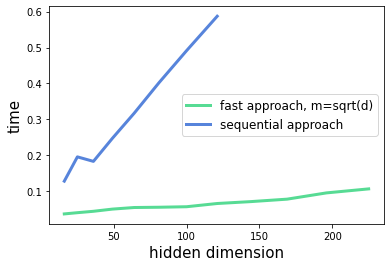

In [53]:
import matplotlib.pyplot as plt
from google.colab import files

plt.figure(figsize=(6, 4))
plt.plot(np.arange(4, 16)**2, time_arr_sqrtd, color=next(color_generator), linewidth=3, label='fast approach, m=sqrt(d)')
plt.plot(np.arange(4, 12)**2, time_seq_arr, color=next(color_generator), linewidth=3, label='sequential approach')
plt.xlabel('hidden dimension', fontsize=15)
plt.ylabel('time', fontsize=15)
plt.legend(fontsize=12)
#plt.savefig('/content/drive/My Drive/graph.png')